### Notebook to code up the method of Poupinet et al. 1984 of precisely calculating differential travel times of earthquake doublets

#### These two events (IDs below) occur within 1 minute of each other and were clustered by GrowClust and are located very close to one another, and therefore will serve as a good example to use to tune the differential time calculation method:

520320
520323

In [56]:
import obspy
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [4]:
# Get original events
file = 'endquakes_2017.xml'
cat = obspy.core.event.read_events(file)

In [57]:
# Pull in their waveforms

path= 'sep2017_mseed/'
fid1 = path+str(520320)+'.mseed'
fid2 = path+str(520323)+'.mseed'
st1 = obspy.read(fid1)
st2 = obspy.read(fid2)

#### The NCHR EHZ channel looks good. Let's try with that one.

In [58]:
tr1 = st1.select(station='NCHR',channel='EHZ')[0].detrend(type='demean')
tr2 = st2.select(station='NCHR',channel='EHZ')[0].detrend(type='demean')
#tr1=tr1.filter('bandpass',freqmin=1,freqmax=15)
#tr2=tr2.filter('bandpass',freqmin=1,freqmax=15)

In [59]:
ev1 = [p for p in cat if str(p.resource_id)[-6:] == str(520320)][0]
ev2 = [p for p in cat if str(p.resource_id)[-6:] == str(520323)][0]

pick1 = ev1.picks[0]
pick2 = ev2.picks[0]

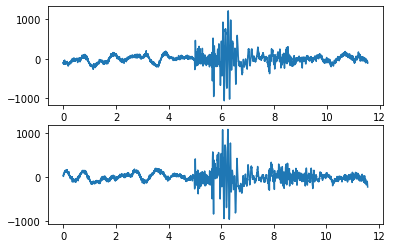

In [60]:
fig,ax=plt.subplots(2,1)
ax[0].plot(tr1.times(),tr1.data)
ax[1].plot(tr2.times(),tr2.data)

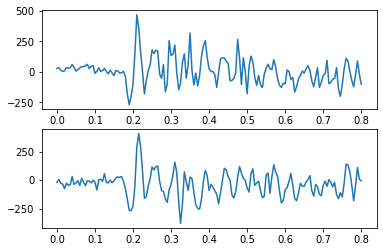

In [61]:
# Just a seismogram around the P-wave, unfiltered:
tr1_trim = tr1.trim(starttime=pick1.time-0.2,endtime=pick1.time+0.6)
tr2_trim = tr2.trim(starttime=pick2.time-0.2,endtime=pick2.time+0.6)
fig,ax=plt.subplots(2,1)
ax[0].plot(tr1_trim.times(),tr1_trim.data)
ax[1].plot(tr2_trim.times(),tr2_trim.data)

In [39]:
# Sliding windows
fs = tr1_trim.stats.sampling_rate
win_len_time = 0.25 # seconds
win_len = int(win_len_time * tr1_trim.stats.sampling_rate)
num_wins = tr1_trim.stats.npts - win_len
taper = scipy.signal.tukey(win_len)

dt = []
for i in range(num_wins):
    win_ind = [i,i+win_len]
    
    # Windowed signal
    s1 = tr1_trim.data[win_ind[0]:win_ind[1]]
    s2 = tr2_trim.data[win_ind[0]:win_ind[1]]

    # Apply the taper
    s1_taper = taper * s1
    s2_taper = taper * s2
    
    # Take Fourier transform
    y1 = scipy.fft.fft(s1_taper)
    y2 = scipy.fft.fft(s2_taper)
    
    # Calculate cross-spectrum of tapered signals
    f,p = scipy.signal.csd(s1,s2, fs=fs,window=taper,scaling='spectrum')

    ph = np.angle(p)
    coeff = np.polyfit(f,ph,1)
    pfit = f*coeff[0]+coeff[1]
    dt.append(coeff[0]/(2*np.pi))

## HOW LONG TO TRIM WINDOW?
## DO I DO THIS SEPARATELY FOR BOTH P AND S WAVES?
## SHOULD I BE FILTERING?

#### Trim to a 1.2 s window, 0.6 s before the pick

In [41]:
tr1_trim = tr1.trim(starttime=pick1.time-0.2,endtime=pick1.time+0.05)
tr2_trim = tr2.trim(starttime=pick2.time-0.2,endtime=pick2.time+0.05)

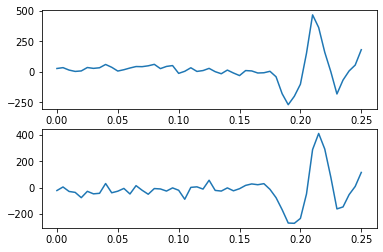

In [42]:
fig,ax=plt.subplots(2,1)
ax[0].plot(tr1_trim.times(),tr1_trim.data)
ax[1].plot(tr2_trim.times(),tr2_trim.data)

#### Apply a 50% cosine taper to the window

Text(0.5, 0, 'Sample')

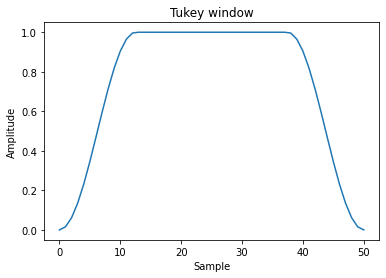

In [43]:
window = scipy.signal.tukey(len(tr1_trim.data))
plt.plot(window)
plt.title("Tukey window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

In [44]:
tr1_taper = window * tr1_trim.data
tr2_taper = window * tr2_trim.data

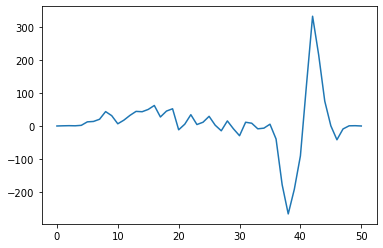

In [45]:
plt.plot(tr1_taper)

#### Calculate Fourier transforms of signals

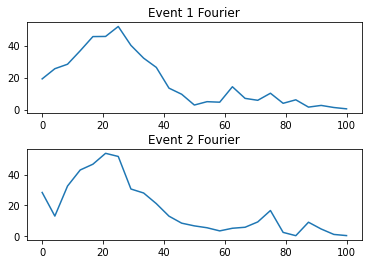

In [46]:
# Number of samplepoints
N = len(tr1_taper)
# sample spacing
T = 1.0 / 200.0
x = np.linspace(0.0, N*T, N)
y = tr1_taper
yf = scipy.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
tr1_fft = yf


fig, ax = plt.subplots(2,1)
ax[0].plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax[0].set_title('Event 1 Fourier')


y = tr2_taper
yf = scipy.fft.fft(y)
tr2_fft = yf
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
ax[1].plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax[1].set_title('Event 2 Fourier')

plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)

#### Calculate cross spectrum of signals

/Users/zoekrauss/anaconda3/envs/alaska-ml/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


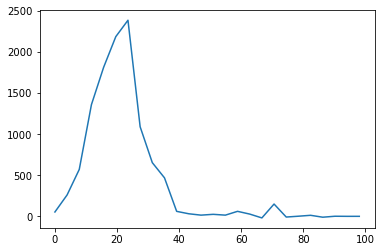

In [47]:
# Or from untapered data through scipy's csd- they return the same signal but different scaling

f,p = scipy.signal.csd(tr1_trim.data, tr2_trim.data, fs=200, window=window,scaling='spectrum')
plt.plot(f,p)

dt = 0.0 s


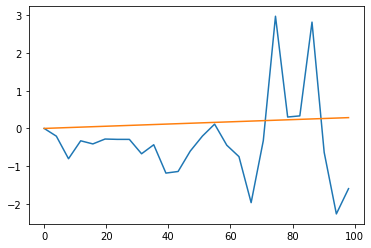

In [51]:
ph = np.angle(p)
test = np.polyfit(f,ph,1)
pfit = f*test[0]
plt.plot(f,np.angle(p))
plt.plot(f,pfit)
dt = pfit[0]/(2*np.pi)
print('dt = '+str(dt)+' s')

## Need to do this in sliding windows and see how consistent the dt is.
## Could also look at the method to do this in the time domain (Deichmann & Garcia-Fernandez 1992)

## Can also try just by finding the sample with maximum correlation?

#### Calculate coherence

In [214]:
coh = (p**2)/(tr1_fft[0:N]*tr2_fft[0:N])
plt.plot(abs(coh))

ValueError: operands could not be broadcast together with shapes (21,) (41,) 

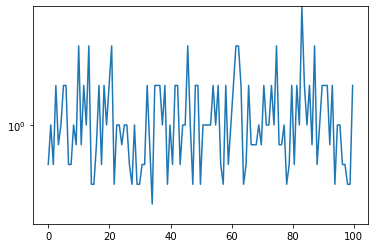

In [182]:
f,ch = scipy.signal.coherence(tr1_trim.data, tr2_trim.data, fs=200, window=window)
plt.semilogy(f,ch)

In [ ]:
tr1_fft = scipy.fft.fft(tr1_taper)[0:]
cross_spec = np.conjugate(tr1_tape)

/Users/zoekrauss/anaconda3/envs/alaska-ml/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


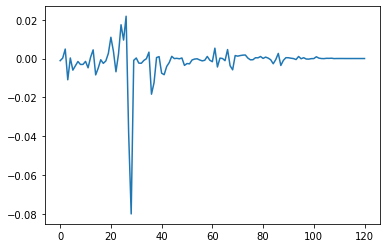

In [161]:
c = (p**2) / (scipy.fft.fft(tr1_taper)[0:121] * scipy.fft.fft(tr2_taper)[0:121])
plt.plot(c)

In [107]:
np.intersect1d(f,freq)

array([ 0.        ,  0.82987552,  1.65975104,  2.48962656,  3.31950207,
        4.14937759,  4.97925311,  5.80912863,  6.63900415,  7.46887967,
        8.29875519,  9.12863071,  9.95850622, 10.78838174, 11.61825726,
       12.44813278, 13.2780083 , 14.10788382, 14.93775934, 15.76763485,
       16.59751037, 17.42738589, 18.25726141, 19.08713693, 19.91701245,
       20.74688797, 21.57676349, 22.406639  , 23.23651452, 24.06639004,
       24.89626556, 25.72614108, 26.5560166 , 27.38589212, 28.21576763,
       29.04564315, 29.87551867, 30.70539419, 31.53526971, 32.36514523,
       33.19502075, 34.02489627, 34.85477178, 35.6846473 , 36.51452282,
       37.34439834, 38.17427386, 39.00414938, 39.8340249 , 40.66390041,
       41.49377593, 42.32365145, 43.15352697, 43.98340249, 44.81327801,
       45.64315353, 46.47302905, 47.30290456, 48.13278008, 48.9626556 ,
       49.79253112, 50.62240664, 51.45228216, 52.28215768, 53.1120332 ,
       53.94190871, 54.77178423, 55.60165975, 56.43153527, 57.26